# Planar Homography

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Auxiliar functions

In [2]:
def get_intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                 [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x, y = np.linalg.solve(A, b)
    x, y = int(x), int(y)
    return (x, y)


In [3]:
def order_points(pts):
    '''Rearrange coordinates to order:
       top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left point will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()


### Read and display original image

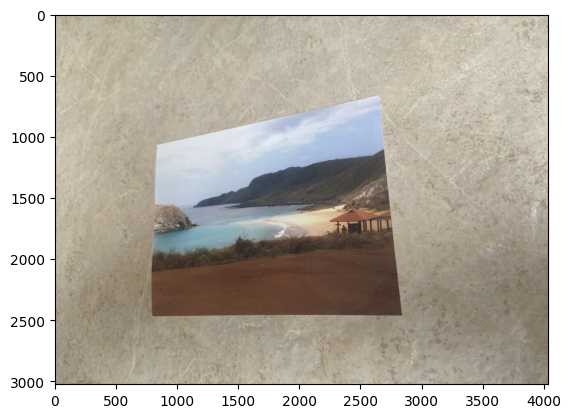

In [4]:
original = cv2.imread('../img/foto1_cap1.jpg')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # check whether this is going to cause problems
plt.imshow(original)
plt.show()

### Resize to workable dims

In [5]:
dim_limit = 1080
max_dim = max(original.shape[:2])
if max_dim > dim_limit:
    resize_scale = dim_limit / max_dim
    original = cv2.resize(original, None, fx=resize_scale, fy=resize_scale)

### Image transforms and morph ops

In [6]:
# convert image to grayscale/blurred versions
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image to create a binary image
ret, thresh = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# perform morphological transformations to remove noise
kernel = np.ones((24, 24), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)

### Background and foreground analysis

In [7]:
# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=35)

# find sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# find unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# add one to all labels so that sure background is not 0, but 1
markers = markers+1

# mark the region of unknown with zero
markers[unknown == 255] = 0

### Watershed

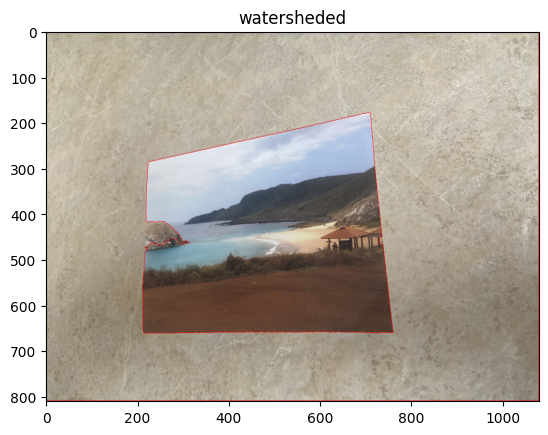

In [8]:
watersheded = original.copy()
markers = cv2.watershed(watersheded, markers)
watersheded[markers == -1] = [255, 0, 0]
plt.imshow(watersheded)
plt.title('watersheded')
plt.show()

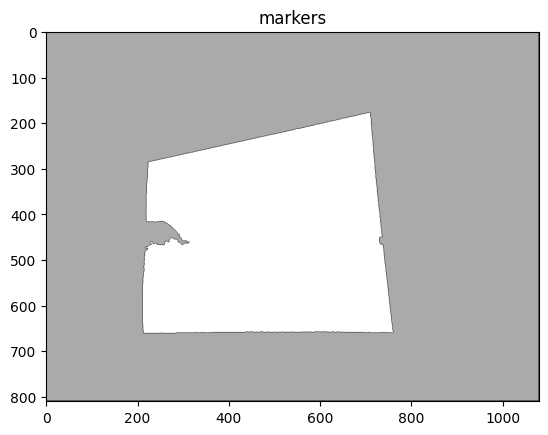

In [9]:
plt.imshow(markers, cmap='gray')
plt.title('markers')
plt.show()

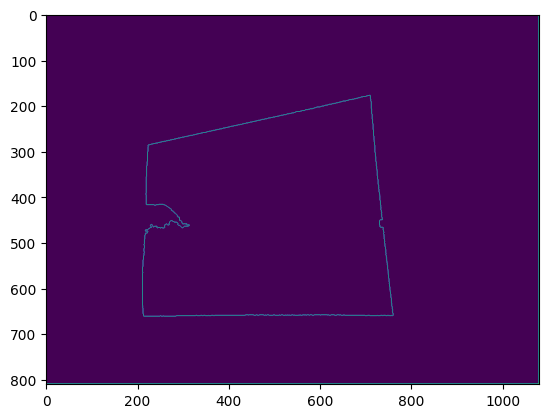

In [10]:
# generate mask image
mask = np.zeros(original.shape[:2], np.uint8)
mask[markers == -1] = 255
plt.imshow(mask)
plt.show()

### Hough lines

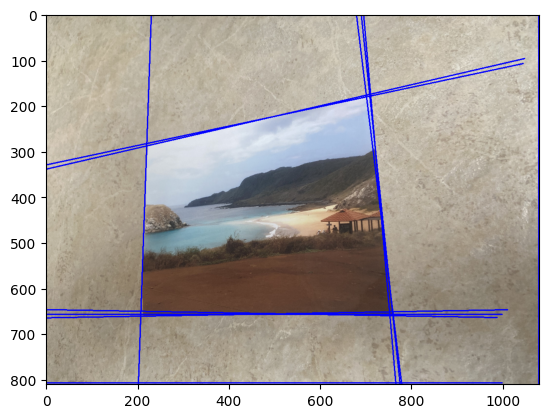

In [11]:
#  perform hough line transform over the mask
lines = cv2.HoughLines(mask, 2, np.pi/180, 150)

# draw lines on the image
lined_img = original.copy()
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(lined_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# show the image with the lines drawn on it
plt.imshow(lined_img)
plt.show()


[GRAB INTERSECTIONS](https://stackoverflow.com/a/46572063)

In [12]:
from collections import defaultdict


def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                   for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

In [13]:
segmented = segment_by_angle_kmeans(lines)

In [14]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Return closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

def segmented_intersections(lines):
    """Finds the intersections between groups of lines"""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2))
    
    return intersections

In [15]:
intersections = segmented_intersections(segmented)

In [36]:
print(intersections)

[[[-1, 807]], [[1079, 807]], [[776, 807]], [[766, 807]], [[203, 807]], [[779, 807]], [[-1, -1]], [[1079, -1]], [[691, -1]], [[696, -1]], [[231, -1]], [[680, -1]], [[-1, 657]], [[1079, 657]], [[760, 657]], [[753, 657]], [[208, 657]], [[761, 657]], [[-1, 340]], [[1079, 91]], [[709, 176]], [[711, 176]], [[221, 289]], [[702, 178]], [[-1, 665]], [[1079, 646]], [[759, 652]], [[753, 652]], [[208, 661]], [[760, 652]], [[-1, 330]], [[1079, 101]], [[710, 179]], [[711, 179]], [[221, 283]], [[702, 181]], [[-1, 647]], [[1079, 666]], [[760, 660]], [[753, 660]], [[208, 651]], [[761, 660]]]


In [90]:
sum_points = []
for point in intersections:
    sum_points.append(np.sum(point))

print(sum_points)

[806, 1886, 1583, 1573, 1010, 1586, -2, 1078, 690, 695, 230, 679, 656, 1736, 1417, 1410, 865, 1418, 339, 1170, 885, 887, 510, 880, 664, 1725, 1411, 1405, 869, 1412, 329, 1180, 889, 890, 504, 883, 646, 1745, 1420, 1413, 859, 1421]


In [41]:
corners = lined_img.copy()
for point in intersections:
    corners = cv2.circle(corners, point[0], radius=10, color=(255,0,0), thickness=-1)

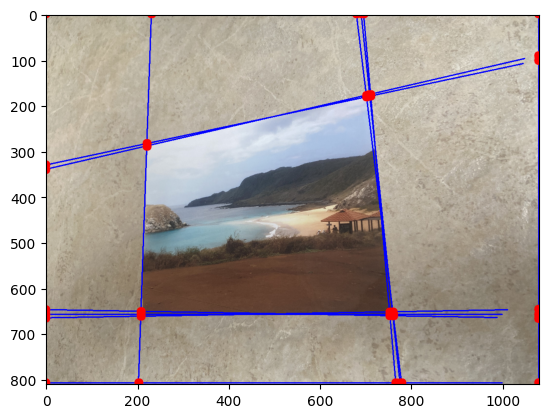

In [31]:
plt.imshow(corners)
plt.show()

### Trying to find correct points

#### K-means

In [98]:
points = []
for point in intersections:
    points.append(point[0])

In [99]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto").fit(points)

In [100]:
corners = lined_img.copy()
centers = list(kmeans.cluster_centers_.astype(int))
centers = [list(point) for point in centers]

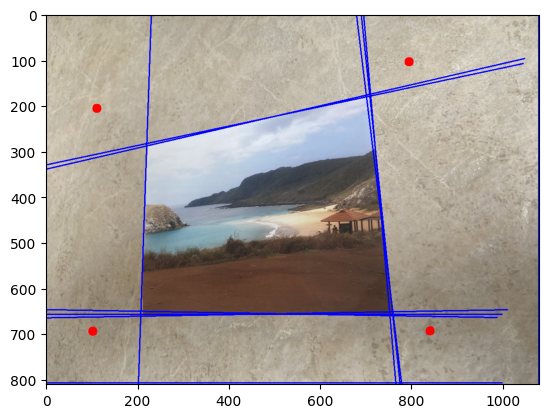

In [101]:
for point in centers:
    x = point[0]
    y = point[1]
    corners = cv2.circle(
        corners, (x, y), radius=10, color=(255, 0, 0), thickness=-1)

plt.imshow(corners)
plt.show()


### Removing outliers

[REMOVE OUTLIERS](https://stackoverflow.com/a/11686764)

In [26]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

### Contour detection

In [22]:
# Blank canvas
con = np.zeros_like(original)
# Finding contours for the detected edges
contours, hierarchy = cv2.findContours(
    im_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the latest detected contour
page = sorted(contours, key=cv2.contourArea, reverse=True)[:3]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

plt.figure(figsize=(10, 7))
plt.imshow(con, cmap='gray')
plt.show()


NameError: name 'im_bin' is not defined

### Corner detection using DP algorithm

[[0, 0], [1079, 0], [1079, 809], [0, 809]]


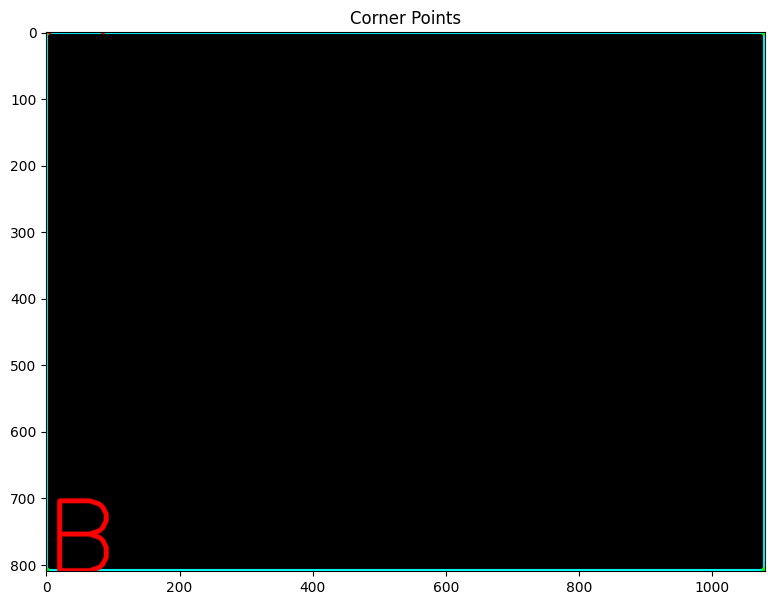

In [ ]:
# Blank canvas
con = np.zeros_like(original)
# Loop over the contours.
for c in page:
    # Approximate the contour.
	epsilon = 0.02 * cv2.arcLength(c, True)
	corners = cv2.approxPolyDP(c, epsilon, True)
	# If our approximated contour has four points
	if len(corners) == 4:
		break

cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())

# displaying corners
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX,
                5, (255, 0, 0), 5, cv2.LINE_AA)

# rearranging the order of the corner points.
corners = order_points(corners)

print(corners)

plt.figure(figsize=(10, 7))
plt.imshow(con)
plt.title('Corner Points')
plt.show()
